In [4]:
import matplotlib.pyplot as plt

In [ ]:
#SEGMENTATION 
#DISCOVERY
#DECODING

In [3]:
def lazyplot(data, scale=1):
    data = [scale*x for x in data]
    plt.plot(list(range(len(data))), data)

In [115]:
with open("sample_reads5.txt", "r") as f:
        data = f.readlines()
data = [int(x) for x in data]
data_binned = [x >> 4 for x in data[1200:2800]]

bins = [0] * 256

for x in data[1200:2200]:
    this_bin = x >> 4
    bins[this_bin] +=1 

sum_range = 4

base = sum(bins[0:sum_range])
sum_list = [0] * len(bins)
sum_list[0] = base

for i in range(0, len(bins)-sum_range):
    this_sum = sum(bins[i:i+sum_range])
    sum_list[i] = this_sum

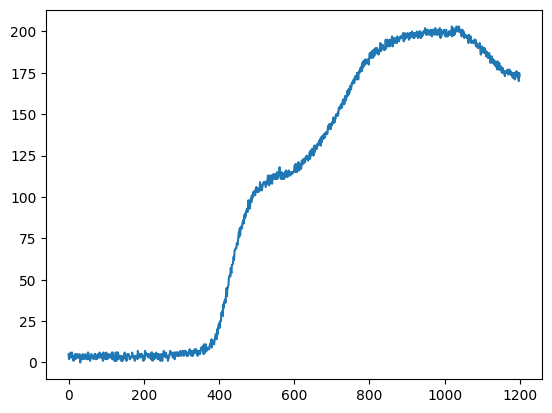

In [116]:
#BINNING

this_data = data[1200:2400]
this_data_binned = [x >> 4 for x in this_data]
lazyplot(this_data_binned)

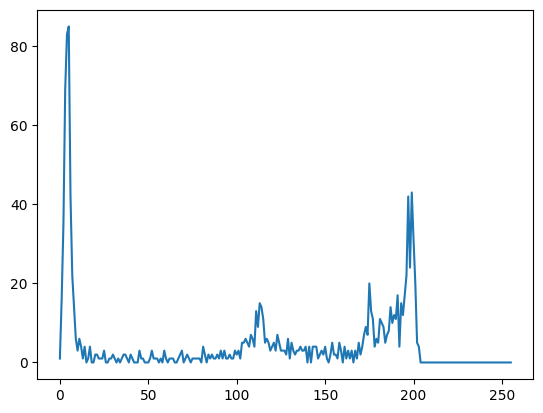

In [99]:
# BIN HISTOGRAM

this_data_hist = [0] * 256
for x in this_data_binned:
    this_data_hist[x]+=1
lazyplot(this_data_hist)

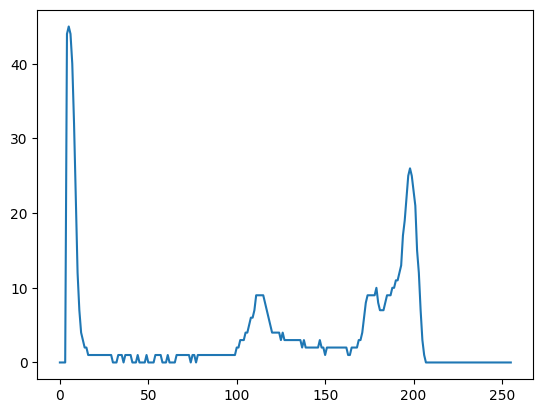

In [103]:
#BIN HISTOGRAM SMOOTHING

this_data_hist_smoothed = [0] * 256
for i in range(256):
    this_data_hist_smoothed[i] = sum(this_data_hist[i-4:i+4])//8
lazyplot(this_data_hist_smoothed)

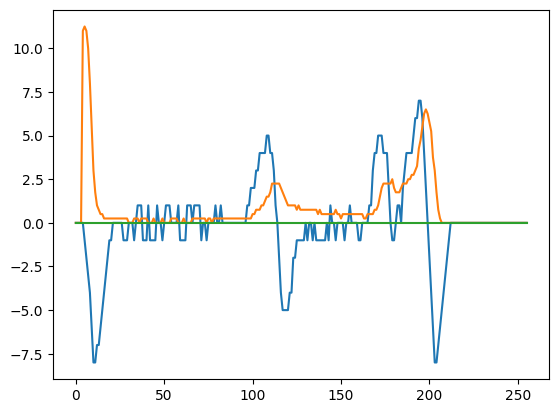

In [114]:
#PATTERN PLOT


this_data_hist_pattern = [0] * 256
for i in range(1, len(this_data_hist_smoothed)): 
    if (a:=this_data_hist_smoothed[i]) == (b:=this_data_hist_smoothed[i-1]):
        this_data_hist_pattern[i] = 0
    elif (a>b):
        this_data_hist_pattern[i] = 1
    else:
        this_data_hist_pattern[i] = -1

window_size = 8
this_data_hist_pattern_summed = [0] * 256
for i in range(0,256):
    this_data_hist_pattern_summed[i] = sum(this_data_hist_pattern[i-window_size//2:i+window_size//2])

lazyplot(this_data_hist_pattern_summed)
lazyplot(this_data_hist_smoothed, 1/4)
lazyplot([0 for i in range(256)])

6
110
192


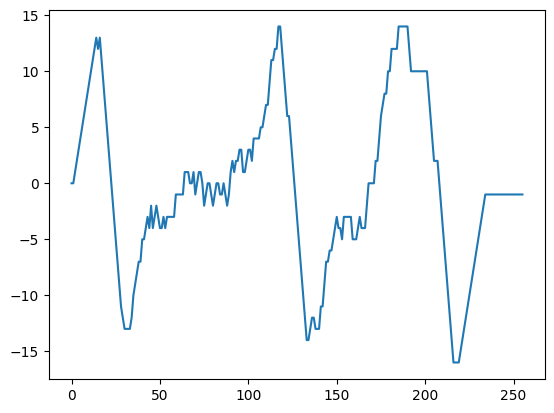

In [15]:
# NON-INCREMENTAL DIFFERENTIAL DECODING

def getleft(array, array_len, pos, dist):
    left = 0 if dist > pos else array[pos-dist]
    return left

def getright(array, array_len, pos, dist):
    right = 0 if (pos+dist > array_len-1) else array[pos+dist]
    return right


bins = [0] * 256
for x in data[1200:2400]:
    bins[x>>4] += 1
def generatePattern(bins):
    pat_sum = 0 
    pattern = [0] * 256
    state =0
    val_sum = 0
    pattern = [0] * 256
    ave_window = [0] * 16
    ave_idx = 0
    closest0 = 0
    for i in range(1, len(bins)):
        
        val_sum += bins[i] - ave_window[ave_idx]
        ave_window[ave_idx] = bins[i]
        ave_idx = ave_idx + 1 if ave_idx < 15 else 0
        bins[i] = val_sum/16
        prev = getleft(bins, len(bins), i, 1)
        if bins[i] > prev:
            pattern[i] = 1
        elif bins[i] < prev:
            pattern[i] = -1
        
        backB = getleft(bins, len(bins), i, 15)
        backA = getleft(bins, len(bins), i, 16)
        diff = 1 if backB > backA else -1
        diff = 0 if backB == backA else diff
        pattern[i] = -diff + pattern[i] + getleft(pattern, len(pattern), i, 1)
        
        if state == 0 and abs(pattern[i] >= 10):
            # print("here")
            state = 1
        if state == 1 and abs(pattern[i]) <=1:
            # print("here2")
            closest0 = i 
            state = 2
        if state == 2 and pattern[i] <= -10:
            # print("here3")
            print(closest0-16)
            state = 3
        if state == 3 and abs(pattern[i]) <= 1:
            state = 0
            # pattern = [0] * 256
            pat_sum = 0
        
    return pattern

lazyplot(generatePattern(bins))

[7, 108, 191, 173, 29, 162]


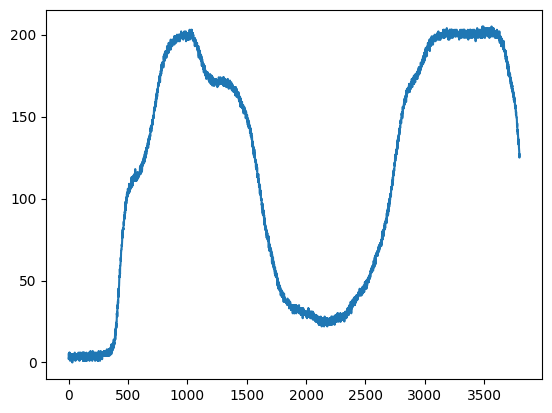

In [26]:
import math
class DifferentialDecoder:
    def __init__(self, Rwidth=12, nBins=256, aveWindowSize=16, threshold=2):
        self.bin_width = int(math.log(nBins, 2))
        self.shift_factor = Rwidth - self.bin_width
        if self.shift_factor < 0:
            raise Exception()
        self.decode_cadence = 50
        self.ave_window_size = aveWindowSize
        self.threshold = 2
        
    @staticmethod
    def getleft(array, array_len, pos, dist):
        left = 0 if dist > pos else array[pos-dist]
        return left
    
    @staticmethod
    def getright(array, array_len, pos, dist):
        right = 0 if (pos+dist > array_len-1) else array[pos+dist]
        return right
    
    def decode (self, sequence):
        res = self.incrementalDecode(sequence)
        return res
        
    def incrementalDecode(self, sequence):
        decode_result = [] 
        i_bin = [0] * 2**8
        ave_window = [0] * self.ave_window_size
        ave_idx = 0
        window_sum = 0
        sup = 0 
        #use iterator so we can work with sequence streams of unknown length
        count = 0
        prev = []
        prev = [0,0,0,0,0]
        for reading in sequence:
            count += 1
            window_sum += reading - ave_window[ave_idx]
            ave_window[ave_idx] = reading
            ave_idx = (ave_idx + 1) if ave_idx < self.ave_window_size-1 else 0
            
            #Embedded implemention uses a right shift but this is good for experimentation
            this_bin = (window_sum//self.ave_window_size)>>self.shift_factor
            
            i_bin[this_bin] += 1
            
            if count >= self.decode_cadence:
                sup += 1
                argbins = [0] * 300
                for (i, x) in enumerate(i_bin):
                    argbins[i] = x
                num_found, pattern = self.pickBins(argbins)
                #Print is for debugging
                # print(num_found, pattern)
              
                if num_found == 2:
                    diff = [abs(x[2] - prev[2]) for x in pattern]

                    if diff[0] < diff[1]:
                        sel,delete = 0, 1
                        prev = pattern[1]
                    else:
                        sel, delete = 1, 0
                        prev = pattern[0]
                    
                            
                    decode_result.append(pattern[sel][2])
                    for i in range (0, pattern[delete][0]-10):
                        i_bin[i] = 0
                    
                    for i in range (pattern[delete][4]+1, 256):
                        i_bin[i] = 0

                count = 0
                
        
        decode_result.append(pattern[0][2])
        return decode_result
                # print(num_found, pattern)
            
    
    def pickBins(self, bins):
        ave_window_size =  self.ave_window_size//4
        ave_window = [0] * ave_window_size
        ave_idx = 0
        window_sum = 0
        pattern = [0] * len(bins)
        state = 0
        found = [[0,], [0,]]
        num_found = 0
        curr = 0
        for i in range(0, len(bins)):
            window_sum += bins[i] - ave_window[ave_idx]
            ave_window[ave_idx] = bins[i]
            ave_idx = ave_idx + 1 if ave_idx < ave_window_size-1 else 0
            bins[i] = window_sum // ave_window_size
            prev = self.getleft(bins, len(bins), i, 1)
            
            if bins[i] > prev:
                pattern[i] = 1
            elif bins[i] < prev:
                pattern[i] = -1
        
            backB = self.getleft(bins, len(bins), i, ave_window_size-1)
            backA = self.getleft(bins, len(bins), i, ave_window_size)
            diff = 1 if backB > backA else -1
            diff = 0 if backB == backA else diff
            pattern[i] = -diff + pattern[i] + self.getleft(pattern, len(pattern), i, 1)
            
            
            if state == 0:
                if abs(pattern[i]) <= 1:
                    if curr >= 2:
                        break
                    found[curr][0] = i
                    
                if pattern[i] >= 3:
                    state = 1
                    found[curr].append(i)
            
            if state == 1:
                if abs(pattern[i]) <= 1:
                    state = 2
                    found[curr].append(i)
            
            if state == 2:
                if pattern[i] <= -3:
                    state = 3
                    found[curr].append(i)
            
            if state == 3:
                if abs(pattern[i]) <= 1:
                    state = 0
                    found[curr].append(i)
                    curr += 1
                    num_found += 1
                    
        return num_found, found
                
       
            
thisDecoder = DifferentialDecoder()
sequence = data[1200:8000]
lazyplot([x>>4 for x in sequence])
result = thisDecoder.decode(sequence)
print(result)
# lazyplot(result)